In [1]:
import numpy as np

**Importing MNIST dataset using Tensorflow**

In this step, we assume you have intmernet connectivity. Connectivity is necessary for this tutorial because the tensorflow library imports the dataset from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz by default. If you do not have internet connectivity, for some strange reason, you can follow our "How to import the MNIST dataset from a local directory" tutorial.

To load the MNIST dataset, use the following code:

In [2]:
from tensorflow.keras.datasets import mnist

The MNIST dataset will be loaded as a set of training and test inputs (X) and outputs (Y). The imputs are samples of digit images while the outputs contain the numerical value each input represents. The exact shape of each dataset is provided below for your convenience.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

/var/folders/z6/4vq2qqgs2078v53wjbxszb8h0000gn/T/ipykernel_5431/4053146574.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
print('MNIST Dataset Shape:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test:  '  + str(x_test.shape))
print('y_test:  '  + str(y_test.shape))

MNIST Dataset Shape:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

**Load the MNIST Dataset**

MNIST dataset consists of thousand images of hand-written digits from 0 to 9. Every image has 28x28 pixels and every pixel's value is between 0 to 255. This dataset is too large for us. So we need to reduce it.

1). Normalizing the pixel's value in the range of [0,1].

2). Filtering images from the dataset, leaving only the images with number 3 and 6 as their labels.

3). Reducing the total number of images in the dataset and divide the dataset into training dataset and testing dataset.

4). Resize the image from 28x28 pixels to 16x16 pixels because QPCA needs the size of the image in the form of 2^n x 2^n pixels.

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
     

Number of original training examples: 60000
Number of original test examples: 10000


In [8]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
# choose the number to be classified here, in this case I selected number 0 and 1
number_set = [0, 1]

mask_train = np.isin(y_train, number_set)
mask_test = np.isin(y_test, number_set)

x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))
     

Number of filtered training examples: 12665
Number of filtered test examples: 2115


In [10]:
y_train

array([0, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [11]:
# next, reduce the number of images inside the dataset

index_train = np.array([], dtype=int)
index_test = np.array([], dtype=int)

# decide how many images we want inside the dataset
num_data = 100
# decide what is the percentage of the dataset we want for the training dataset
train_percentage = 0.8

# train data
counter = np.array([0,0], dtype=int)
for i in range (len(x_train)):
    if y_train[i] == True and counter[0] < int(train_percentage*num_data/2):
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_train[i] == False and counter[1] < int(train_percentage*num_data/2):
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[1] += 1

# test data
counter = np.array([0,0], dtype=int)
for i in range (len(x_test)):
    if y_test[i] == True and counter[0] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_test[i] == False and counter[1] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[1] += 1

x_train = x_train[index_train]
y_train = y_train[index_train]
x_test = x_test[index_test]
y_test = y_test[index_test]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(80, 28, 28, 1) (80,)
(20, 28, 28, 1) (20,)


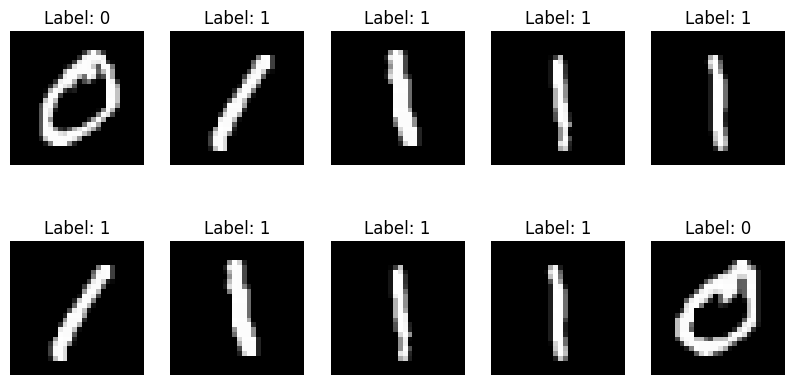

In [12]:
# Print some images from the final dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(2):
    for j in range(5):
        axes[i, j].imshow(x_train[i + j].squeeze(), cmap='gray')
        axes[i, j].set_title("Label: {}".format(y_train[i + j]))
        axes[i, j].axis('off')

plt.show()

0


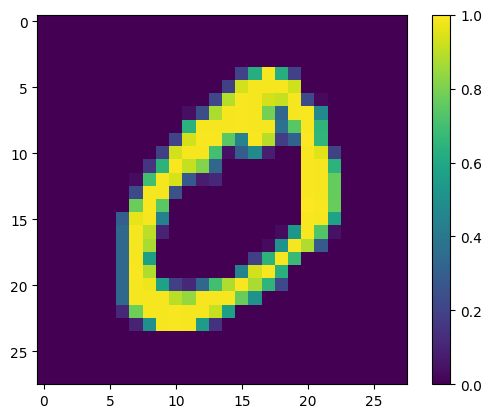

In [13]:
# plot an example of 1 image

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [14]:
# resize the images

x_train_small = tf.image.resize(x_train, (16,16)).numpy()
x_test_small = tf.image.resize(x_test, (16,16)).numpy()
     

0


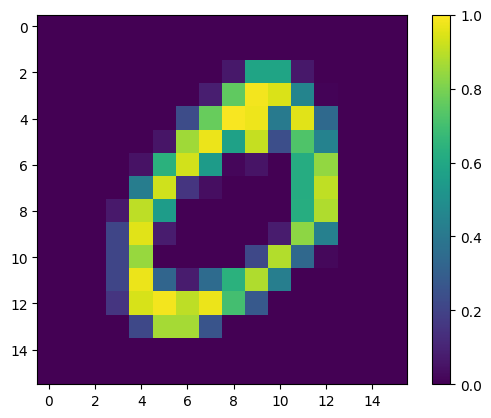

In [15]:
# plot an example of 1 resized image

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [16]:
x_train_small.shape

(80, 16, 16, 1)

**Classical Principal Component Analysis**

We will use the well-known scikit-learn package for the classical PCA (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [16]:
# decide the number of principal components to be used
n_components_classic = 8

pca = PCA(n_components=n_components_classic, whiten = False, random_state = 2020)

In [17]:
x_train_small_pca = pca.fit_transform(x_train_small.reshape(len(x_train_small),16**2))
x_test_small_pca = pca.fit_transform(x_test_small.reshape(len(x_test_small),16**2))
x_train_small_pca.shape, x_test_small_pca.shape

((80, 8), (20, 8))

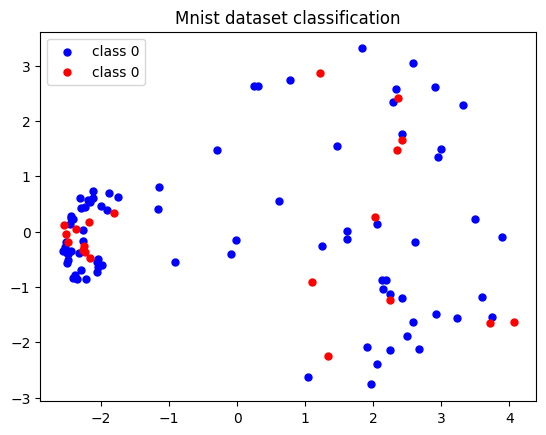

In [18]:
plt.scatter(x_train_small_pca[:,0], x_train_small_pca[:,1], c='b', marker="o", label="class 0", s=25)
plt.scatter(x_test_small_pca[:,0], x_test_small_pca[:,1], c='r', marker="o", label="class 0", s=25)

plt.title("Mnist dataset classification")
plt.legend(loc='upper left')

In [ ]:
np.save('x_train_small_pca.npy', x_train_small_pca)
np.save('x_test_small_pca.npy', x_test_small_pca)
np.save('y_test.npy', y_test)
np.save('y_train.npy', y_train)